
## Radio Pulmonaires pour l'analyse du COVID19
### DataScientest : Bootcamp DataScientist
Octobre 2024

#### On commence par importer les packages qui seront utiles
(Remarque il faut les installer préalablement opencv-python  -> cv2)

In [2]:
# Import des packages

# Naviguer dans les répertoire

import os

## Data preprocessing
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import cv2


Les données ont été téléchargées préalablement. 
Elles sont dispo sous : https://www.kaggle.com/code/ahmedtronic/covid-19-radiology-vgg19-f1-score-95

Il y a trois dossiers (COVID, Lung_Opacity et Normal) contenant chacun plusieurs millieurs d'images et les masques associés
Il faudra les importer, les annoter en fonction de leur dossier initial, les préprocesser pour pouvoir les exploiter ensuite en classification

# On explore pour une image


Le format de l'image est :  (299, 299, 3)


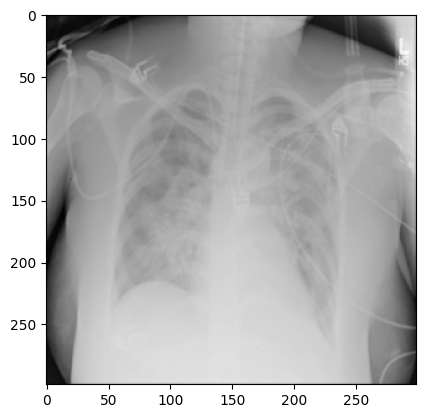

In [21]:
img_color = cv2.imread(r"./COVID-19_Radiography_Dataset\Lung_Opacity\images\Lung_Opacity-10.png",cv2.IMREAD_COLOR)

print("Le format de l'image est : ", img_color.shape)

plt.imshow(img_color)


Le format de l'image est :  (299, 299)


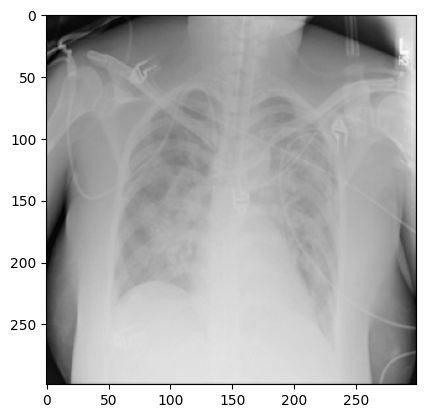

In [25]:

img_grey = cv2.imread(r"./COVID-19_Radiography_Dataset\Lung_Opacity\images\Lung_Opacity-10.png",cv2.IMREAD_GRAYSCALE)

print("Le format de l'image est : ", img_grey.shape)

plt.imshow(img_grey,cmap="gray")


#Visuellement il semble y avoir peu de différence entre l'image en nuance de gris ou en couleur, on part dans un premier temps sur les données en gris


Le format du masque est :  (256, 256)


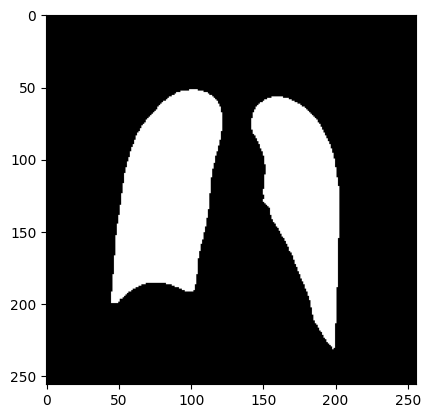

In [23]:
 # On lit le masque correspondant et on l'applique

mask_grey = cv2.imread(r"./COVID-19_Radiography_Dataset\Lung_Opacity\masks\Lung_Opacity-10.png",cv2.IMREAD_GRAYSCALE)

print("Le format du masque est : ", mask_grey.shape)

plt.imshow(mask_grey,cmap="gray")


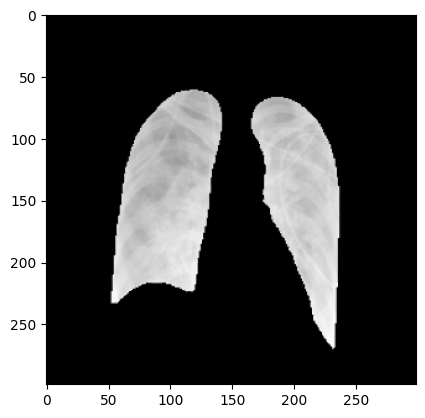

In [28]:

# On applique le masque 

# On redimensionne le masque au format de l image car l'un est en 256*256 l'autre en 299*299

mask_grey2 = cv2.resize(mask_grey, dsize = img_grey.shape[:2])

# 
masked_image = cv2.bitwise_and(img_grey, mask_grey2) # pour masquer mon_image

plt.imshow(masked_image,cmap="gray")

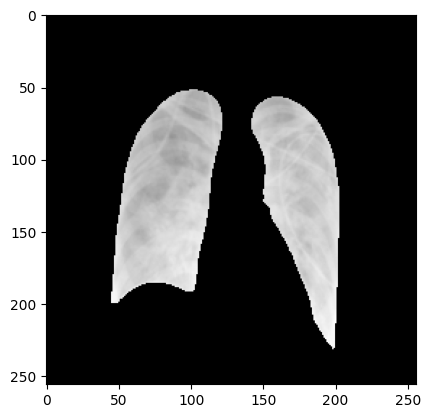

In [30]:
# On essaye pour voir s'il ne vaut pas mieux redimensionner l'image 

img_grey2 = cv2.resize(img_grey, dsize = mask_grey.shape[:2])

# 
masked_image2 = cv2.bitwise_and(img_grey2, mask_grey) # pour masquer mon_image

plt.imshow(masked_image2,cmap="gray")

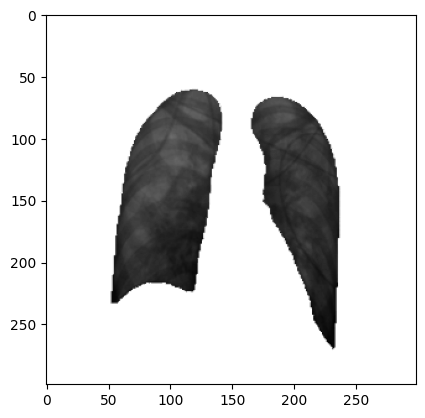

In [47]:
# On applique une normalisation de gauss

gauss_image = cv2.GaussianBlur(masked_image, ksize = (3,3), sigmaX=0.2)

plt.imshow(gauss_image,cmap="gray")

# Peut être serait il utile de passer en negatif
# gauss_image_neg = 255 - gauss_image
# plt.imshow(gauss_image_neg,cmap="gray")

# A creuser pour s avoir s il serait utile d'utilise erode pour supprimer les electrodes
# ou threshold pour supprimer ce qui est trop blanc ?

Il faut a present stocker l image dans un vecteur

In [79]:
# On la transforme en format 

a = np.arange(6).reshape((3, 2))

print(a)

a.reshape(6)

# On transforme en vecteur 
gauss_vector = gauss_image.reshape(1,gauss_image.shape[0]*gauss_image.shape[1])

gauss_df  = pd.DataFrame(gauss_vector)

gauss_df["id"] = ("lung_opacity10")
gauss_df["type"] = ("lung_opacity")
#gauss_df["id","type"]= ("lung opacity"

gauss_df.set_index("id")

#gauss_line.append([gauss_vector])

gauss_df


[[0 1]
 [2 3]
 [4 5]]


,0,1,2,3,4,5,6,7,8,9,...,89393,89394,89395,89396,89397,89398,89399,89400,id,type
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,lung_opacity10,lung_opacity


In [147]:
# On stocle le df de lung opacity

df_lung_opacity = df

# On va travailler sur les 500 premieres images de chaque categorie

## On importe les images en les preprocessant
### Application du masque
### Application d'un filtre gaussien
### On transforme le tout en dataset


In [61]:
df  = None

for type in  ["Lung_Opacity","COVID","Normal","Viral_Pneumonia"] :
    print(type)
    list = os.listdir(os.path.join("./COVID-19_Radiography_Dataset",type,"images"))
    #print(list[:10])
    for filename in list[:500] :
        #print(type,filename,os.path.join("./COVID-19_Radiography_Dataset",type,"images",filename))
        img = cv2.imread(os.path.join("./COVID-19_Radiography_Dataset",type,"images",filename),cv2.IMREAD_GRAYSCALE) # import de l'image
        mask = cv2.imread(os.path.join("./COVID-19_Radiography_Dataset",type,"masks",filename),cv2.IMREAD_GRAYSCALE) # import du masque 
        mask2 = cv2.resize(mask, dsize = img.shape[:2])  # pour remettre les dimensions du masque à celle de l'image
        masked_img = cv2.bitwise_and(img, mask2) # pour masquer l'image
        #plt.imshow(masked_img,cmap="gray")
        gauss_img = cv2.GaussianBlur(masked_img, ksize = (3,3), sigmaX=0.2)
        gauss_df = pd.DataFrame(gauss_img.reshape(1,gauss_img.shape[0]*gauss_img.shape[1]),index = [filename.split(".")[0]])
        #gauss_df["id"] = filename.split(".")[0]
        gauss_df["type"] = type
        
        if df is None :
           df  = gauss_df
        
        else:
        
           df = pd.concat([df, gauss_df])


    

Lung_Opacity
COVID
Normal
Viral_Pneumonia


## On supprime les variables identiques pour tout le monde

In [64]:

#display(data.describe())

# On voit si on peut eliminer les colonnes non variables
data = df.loc[:, (df != df.iloc[0]).any()] 

print("On elimine", df.shape[1] - data.shape[1], "variables identiques pour tous les échantillons")



# On exporte le jeu de données 

#data.to_csv("tab_reduit_images.csv")  



On elimine 2280 colonnes identiques pour tous les échantillons


## Nombre de données par catégories, moyennes et écart-type

Moyenne des valeurs par catégorie


type
COVID              32.862565
Lung_Opacity       25.164394
Normal             24.340970
Viral_Pneumonia    27.580441
dtype: float64

Ecart type des moyennes par catégorie


type
COVID              32.935917
Lung_Opacity       29.314968
Normal             32.219216
Viral_Pneumonia    37.522791
dtype: float64

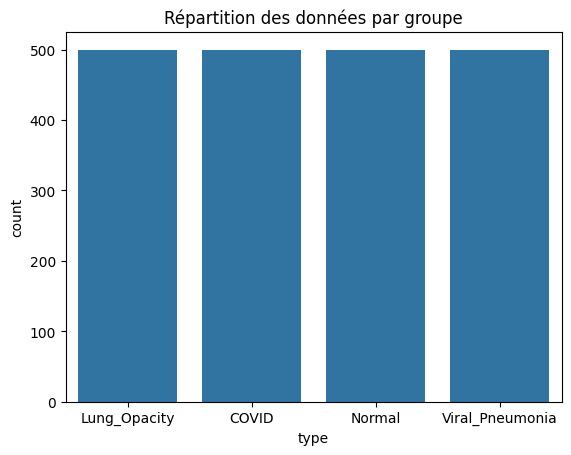

In [65]:
# On compte le nombre d'occurrence par groupe

sns.countplot(x=data["type"])
plt.title("Répartition des données par groupe")

# On fait la moyenne des valeurs et écart type par groupe
print("Moyenne des valeurs par catégorie")
display(data.groupby("type").mean().mean(axis=1))
print("Ecart type des moyennes par catégorie")
display(data.groupby("type").mean().std(axis=1))


## Visualiser une différence dans les valeurs des différents pixels selon les catégories
On trace un graph de la moyenne par pixel par groupe

In [45]:
# On essaye de tracer un graph de la moyenne par pixel par groupe

data_grouped = data.groupby("type").agg("mean")

data_grouped.head()

# On pourrait tracer le graph en bouclant variable par variable mais c'est très long !!! 
# # Tracer le graphique
# fig, ax = plt.subplots()
# for col in data_grouped.columns[1:]:
#     ax.plot(data_grouped['type'], data_grouped[col], marker='o', label=col)

# ax.set_xlabel('Categorie')
# ax.set_ylabel('Moyenne')
# ax.set_title('Moyennes de la valeur par Catégorie')
# ax.legend()
# plt.show()


,8,9,10,11,12,13,14,15,16,17,...,89388,89389,89390,89391,89392,89393,89394,89395,89396,89397
type,,,,,,,,,,,,,,,,,,,,,
COVID,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.00,0.000,...,1.008,0.670,0.672,0.626,0.306,0.314,0.328,0.338,0.344,0.1
Lung_Opacity,0.128,0.17,0.158,0.152,0.152,0.156,0.16,0.158,0.15,0.144,...,0.314,0.306,0.298,0.298,0.304,0.314,0.322,0.042,0.000,0.0
Normal,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.00,0.000,...,0.206,0.216,0.222,0.068,0.000,0.000,0.000,0.000,0.000,0.0
Viral_Pneumonia,0.000,0.00,0.000,0.000,0.000,0.000,0.00,0.000,0.00,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0


,level_0,type,0
0,8,COVID,0.000
1,8,Lung_Opacity,0.128
2,8,Normal,0.000
3,8,Viral_Pneumonia,0.000
4,9,COVID,0.000


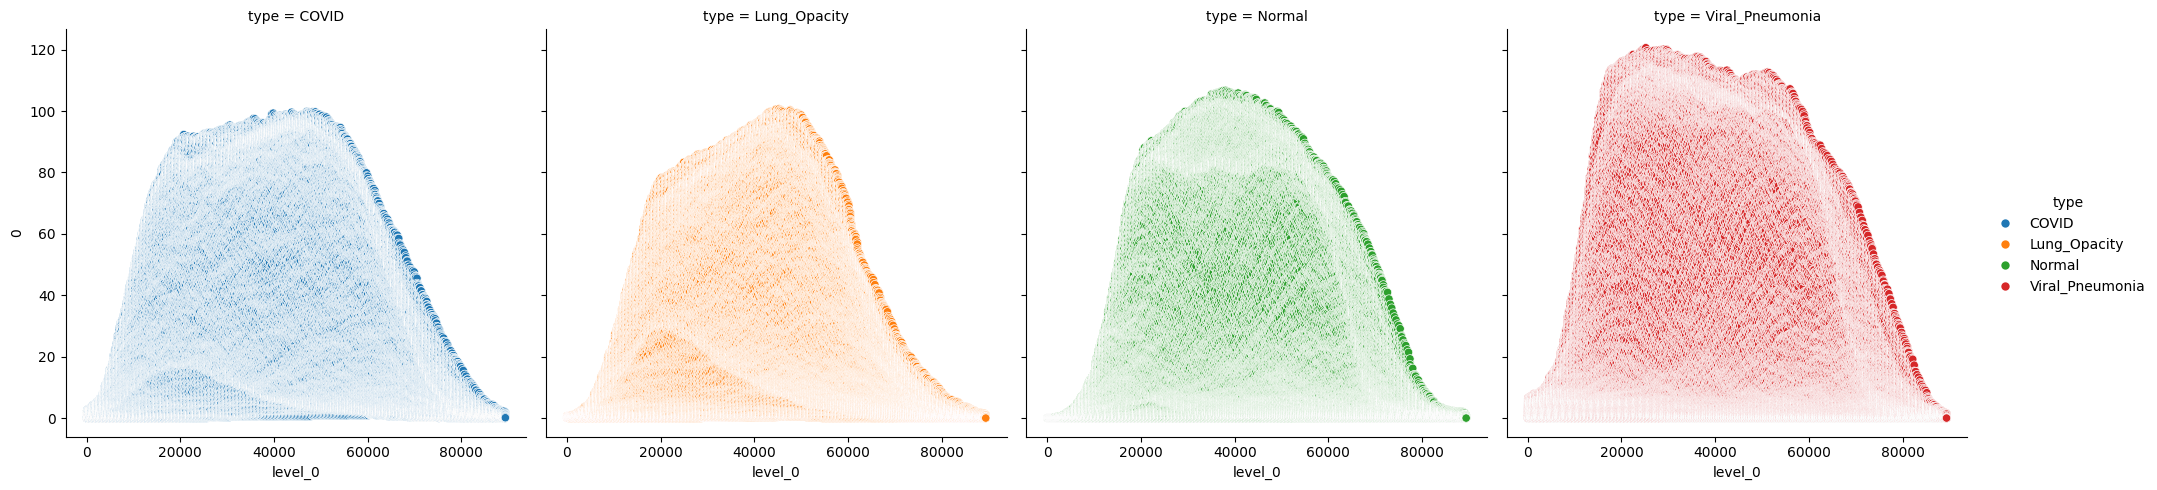

In [69]:
# On fait un unstack et on affiche le graph

group2 = data_grouped.unstack().reset_index()

# print(group2.columns,group2.shape)

display(group2.head())

sns.relplot(data=group2,x="level_0", y= 0, col='type',hue="type")


On visualise sous forme de boxplot

In [76]:
# Autre option on transpose ce qui permet de gérer les données plus facilement
moyenne = data_grouped.transpose()

display(moyenne.head())

type,COVID,Lung_Opacity,Normal,Viral_Pneumonia
8,0.0,0.128,0.0,0.0
9,0.0,0.170,0.0,0.0
10,0.0,0.158,0.0,0.0
11,0.0,0.152,0.0,0.0
12,0.0,0.152,0.0,0.0


type,COVID,Lung_Opacity,Normal,Viral_Pneumonia
count,87121.000000,87121.000000,87121.000000,87121.000000
mean,32.862565,25.164394,24.340970,27.580441
std,32.935917,29.314968,32.219216,37.522791
min,0.000000,0.000000,0.000000,0.000000
25%,3.018000,1.432000,0.472000,0.320000
50%,19.408000,10.636000,5.184000,5.544000
75%,62.078000,44.290000,44.376000,48.966000
max,99.882000,100.694000,106.734000,120.632000


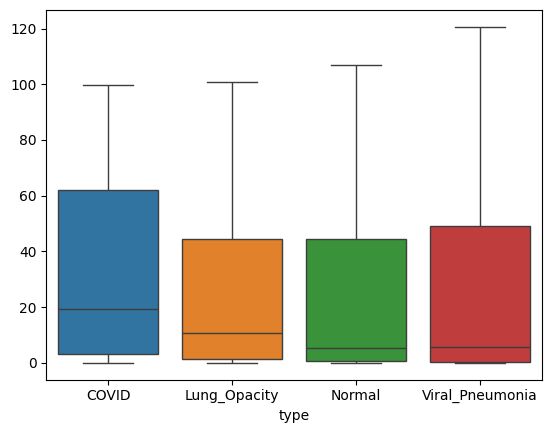

In [78]:
sns.boxplot(moyenne)

display(moyenne.describe())

<Axes: xlabel='type'>

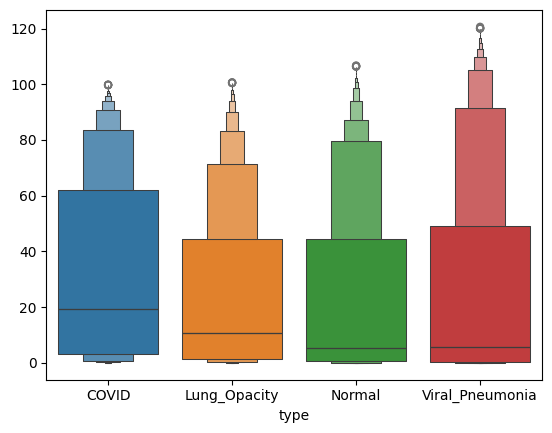

In [79]:
sns.boxenplot(moyenne)